In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/License_CC_BY_NC_SA_3.0.txt
/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/test/HGG_LGG/brats_2013_pat0117_1/VSD.Brain.XX.O.MR_Flair.54221.mha
/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/test/HGG_LGG/brats_2013_pat0117_1/VSD.Brain.XX.O.MR_T1.54222.mha
/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/test/HGG_LGG/brats_2013_pat0117_1/VSD.Brain.XX.O.MR_T2.54224.mha
/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/test/HGG_LGG/brats_2013_pat0117_1/VSD.Brain.XX.O.MR_T1c.54223.mha
/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/test/HGG_LGG/brats_tcia_pat500_0002/VSD.Brain.XX.O.MR_Flair.40811.mha
/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/test/HGG_LGG/brats_tcia_pat500_0002/VSD.Brain.XX.O.MR_T1c.40813.mha
/kaggle/input/brain-tumor-segmentation-in-mri-brats-2015/test/HGG_LGG/brats_tcia_pat500_0002/VSD.Brain.XX.O.MR_T1.40814.mha
/kaggle/input/brain-tumor-segmentation-in-mri-b

# **About The Dataset**

The Multimodal Brain Tumor Image Segmentation Benchmark (BRATS) is a challenge focused on brain tumor segmentation and occurs on an yearly basis on MICCAI.
This dataset, from the 2015 challenge, contains data and expert annotations on four types of MRI images:

* T1
* T1c
* T2
* FLAIR

We are provided with four types of MRI for each patient.

In training dataset we are provided with two types of brain gilomas and each patient consists of 4 MRI and segmented tumor image.

In test dataset we are provided with four MRI images our task is to find the segmented image of Tumor and on the basis of this segmented tumor predict the HGG LGG gilomas

# **APPORACH USED FOR PROBLEM**

* First we preprocessed the dataset.
  * In preprocessing steps we use the windows tecniques(which used by the doctors to analyze the MRI) 
  * Then adjust the pixel array according to colorspace. 
  * Then use the masking techniques to highlight only the required part.
  * Then normalize and crop the images.
* Then use the U-Net segmentation architecture for learining the segmentation on Brain MRI images.
* We then pass the result of segmentation model to a classifier to classify in HGG and LGG.


**Image Preprocessing**

* For reading the .mha extension file SimpleITK library is used
* For visulization of the image the image is converted into 2D slices.

In [2]:
import os
import numpy
import SimpleITK
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:


def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
#     nda=numpy.transpose(nda)
#     print(nda.shape)
    #spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    #extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

In [4]:
# Paths to the .mhd files
filenameF = "../input/brain-tumor-segmentation-in-mri-brats-2015/train/HGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_Flair.54584.mha"
filenameT1 = "../input/brain-tumor-segmentation-in-mri-brats-2015/train/HGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T1.54585.mha"
filenameT2="../input/brain-tumor-segmentation-in-mri-brats-2015/train/HGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T2.54587.mha"
filenameTC="../input/brain-tumor-segmentation-in-mri-brats-2015/train/HGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T1c.54586.mha"
# Slice index to visualize with 'sitk_show'
label="../input/brain-tumor-segmentation-in-mri-brats-2015/train/HGG/brats_2013_pat0013_1/VSD.Brain_3more.XX.O.OT.54589.mha"

filenameLF="../input/brain-tumor-segmentation-in-mri-brats-2015/train/LGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_Flair.54674.mha"
filenameLT1="../input/brain-tumor-segmentation-in-mri-brats-2015/train/LGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T1.54675.mha"
filenameLT2="../input/brain-tumor-segmentation-in-mri-brats-2015/train/LGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T2.54677.mha"
filenameLTC="../input/brain-tumor-segmentation-in-mri-brats-2015/train/LGG/brats_2013_pat0013_1/VSD.Brain.XX.O.MR_T1c.54676.mha"

labelL="../input/brain-tumor-segmentation-in-mri-brats-2015/train/LGG/brats_2013_pat0013_1/VSD.Brain_2more.XX.O.OT.54679.mha"
# idxSlice = 100
idxSlice = 105


# int label to assign to the segmented gray matter
labelGrayMatter = 1

In [5]:
imgFOriginal = SimpleITK.ReadImage(filenameF)
imgT1Original = SimpleITK.ReadImage(filenameT1)
imgT2Original = SimpleITK.ReadImage(filenameT2)
imgTCOriginal = SimpleITK.ReadImage(filenameTC)
labelOrignal=SimpleITK.ReadImage(label)
# print(labelOrignal)
imgLFOriginal = SimpleITK.ReadImage(filenameLF)
imgLT1Original = SimpleITK.ReadImage(filenameLT1)
imgLT2Original = SimpleITK.ReadImage(filenameLT2)
imgLTCOriginal = SimpleITK.ReadImage(filenameLTC)
labelLOrignal=SimpleITK.ReadImage(labelL)


HGG


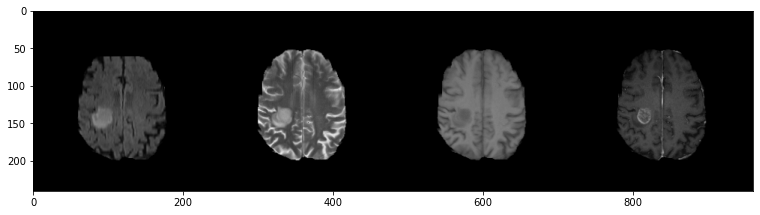

Label


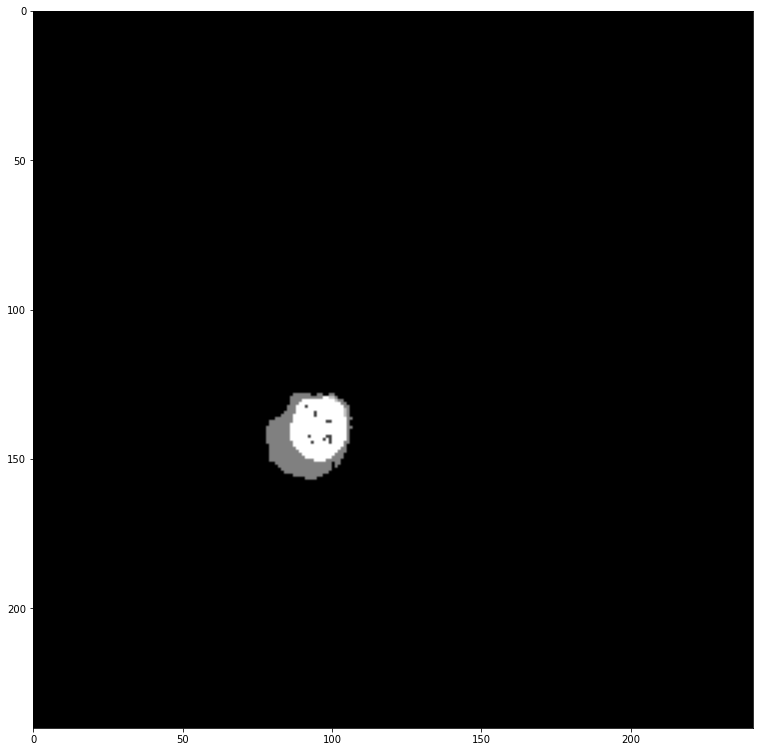

In [6]:
print("HGG")
sitk_show(SimpleITK.Tile(imgFOriginal[:, :, 105],
                         imgT2Original[:, :, 105],
                         imgT1Original[:, :, 105],
                         imgTCOriginal[:, :, 105],
                         (5, 1, 0)))

print("Label")
sitk_show(SimpleITK.Tile(labelOrignal[:,:,105],(2,1,0)))

# print("Label")
# sitk_show(labelOrignal[:,:,105])


LGG


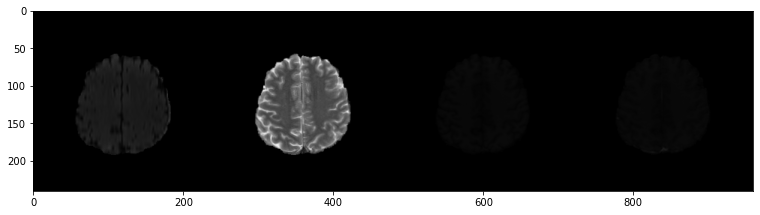

Label


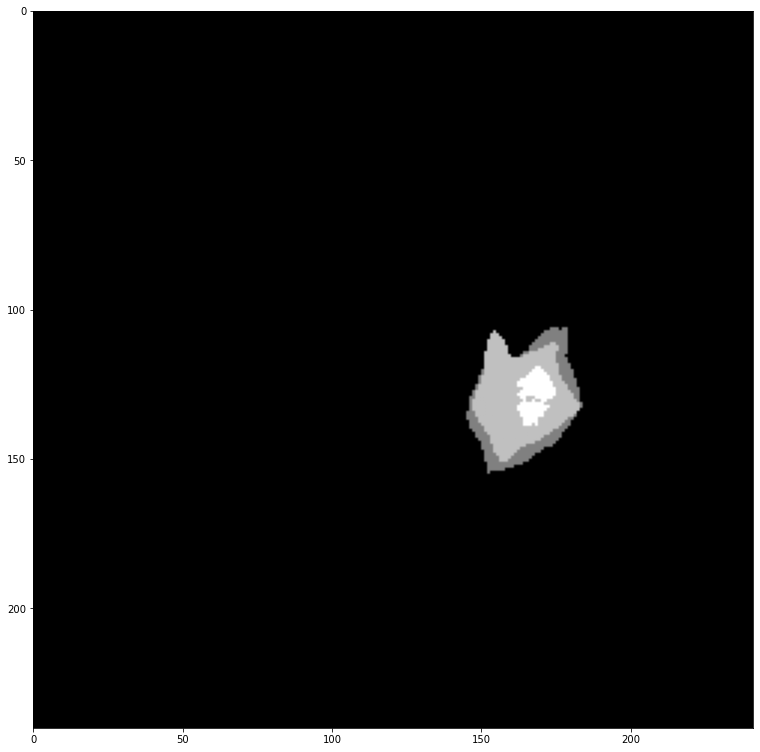

In [7]:
print("LGG")
sitk_show(SimpleITK.Tile(imgLFOriginal[:, :, idxSlice],
                         imgLT2Original[:, :, idxSlice],
                         imgLT1Original[:, :, idxSlice],
                         imgLTCOriginal[:, :, idxSlice],
                         (4, 1, 0)))

print("Label")
sitk_show(SimpleITK.Tile(labelLOrignal[:,:,75],(2,1,0)))

**Image Smoothing/Denoising**

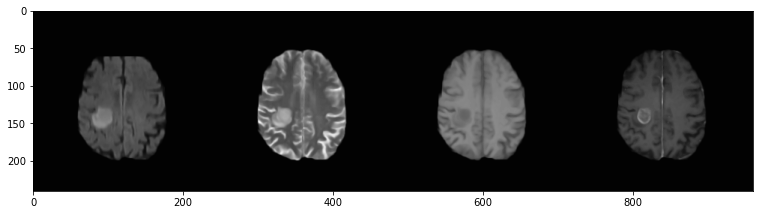

In [8]:
imgFSmooth = SimpleITK.CurvatureFlow(image1=imgFOriginal,
                                      timeStep=0.125,
                                      numberOfIterations=5)

imgT2Smooth = SimpleITK.CurvatureFlow(image1=imgT2Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)
imgT1Smooth = SimpleITK.CurvatureFlow(image1=imgT1Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

imgTCSmooth = SimpleITK.CurvatureFlow(image1=imgTCOriginal,
                                      timeStep=0.125,
                                      numberOfIterations=5)
# imgLSmooth=SimpleITK.CurvatureFlow(image1=labelOrignal,
#                                       timeStep=0.125,
#                                       numberOfIterations=5)
sitk_show(SimpleITK.Tile(imgFSmooth[:, :, 105], 
                         imgT2Smooth[:, :, 105], 
                         imgT1Smooth[:, :, 105], 
                         imgTCSmooth[:, :, 105],
                         (5, 1, 0)))




LGG


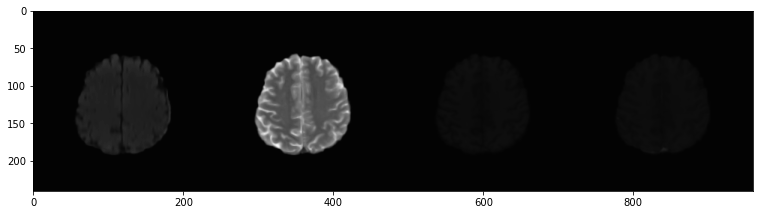

In [9]:
print("LGG")
imgLFSmooth = SimpleITK.CurvatureFlow(image1=imgLFOriginal,
                                      timeStep=0.125,
                                      numberOfIterations=5)

imgLT2Smooth = SimpleITK.CurvatureFlow(image1=imgLT2Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)
imgLT1Smooth = SimpleITK.CurvatureFlow(image1=imgLT1Original,
                                      timeStep=0.125,
                                      numberOfIterations=5)

imgLTCSmooth = SimpleITK.CurvatureFlow(image1=imgLTCOriginal,
                                      timeStep=0.125,
                                      numberOfIterations=5)
sitk_show(SimpleITK.Tile(imgLFSmooth[:, :, idxSlice], 
                         imgLT2Smooth[:, :, idxSlice], 
                         imgLT1Smooth[:, :, idxSlice], 
                         imgLTCSmooth[:, :, idxSlice], 
                         (4, 1, 0)))

**Seeding**

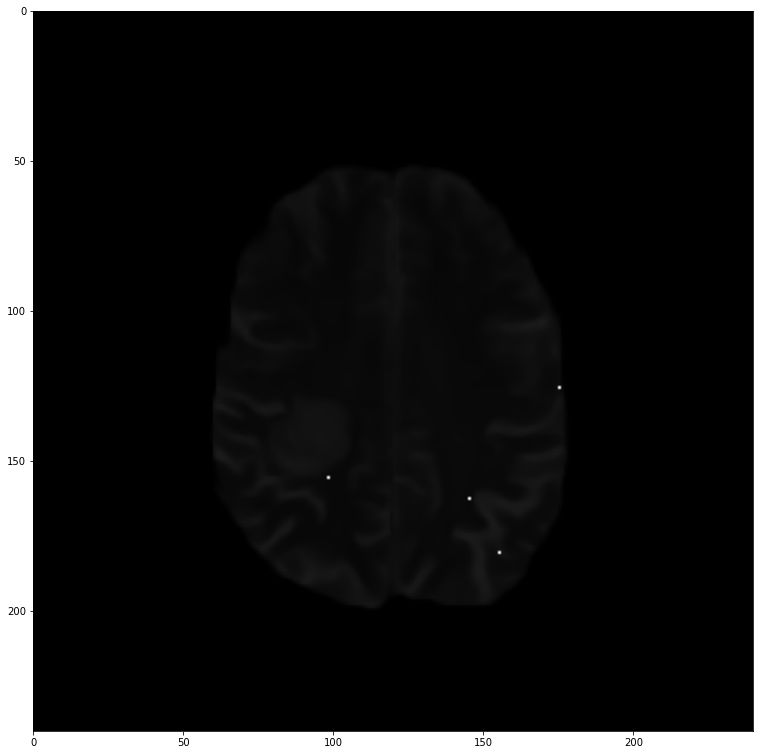

In [10]:
lstSeeds = [(145, 162, idxSlice),
            (98, 155, idxSlice),
            (175, 125, idxSlice),
            (155, 180, idxSlice)]

imgSeeds = SimpleITK.Image(imgT2Smooth)

for s in lstSeeds:
    imgSeeds[s] = 10000

sitk_show(imgSeeds[:, :, idxSlice])



LGG


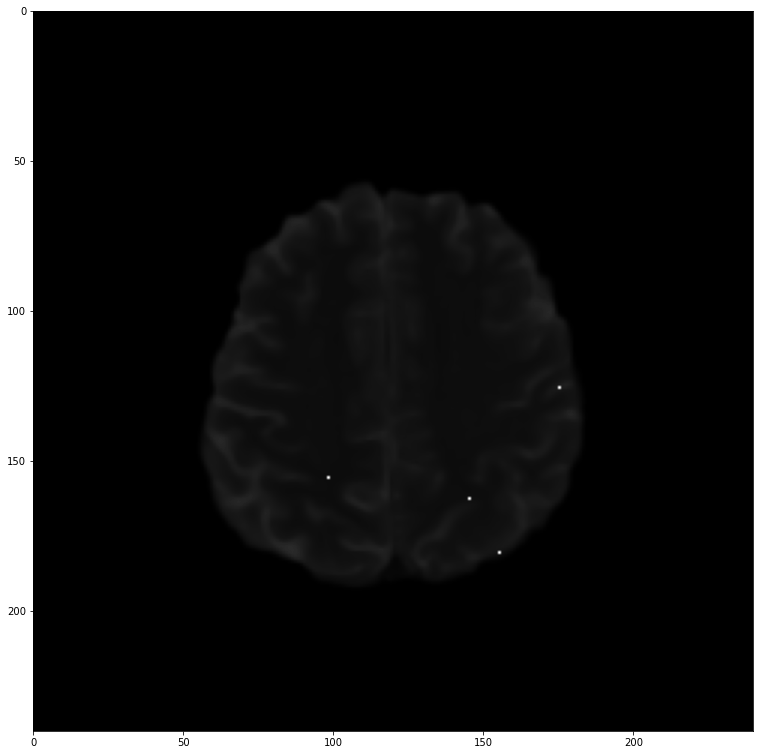

In [11]:
print("LGG")
lstSeeds = [(145, 162, idxSlice),
            (98, 155, idxSlice),
            (175, 125, idxSlice),
            (155, 180, idxSlice)]

imgSeeds = SimpleITK.Image(imgLT2Smooth)

for s in lstSeeds:
    imgSeeds[s] = 10000

sitk_show(imgSeeds[:, :, idxSlice])



**Auxiliary Function: Vector-Image Tiling**

In [12]:
def sitk_tile_vec(lstImgs):
    lstImgToCompose = []
    for idxComp in range(lstImgs[0].GetNumberOfComponentsPerPixel()):
        lstImgToTile = []
        for img in lstImgs:
            lstImgToTile.append(SimpleITK.VectorIndexSelectionCast(img, idxComp))
        lstImgToCompose.append(SimpleITK.Tile(lstImgToTile, (len(lstImgs), 0, 0)))
    sitk_show(SimpleITK.Compose(lstImgToCompose))

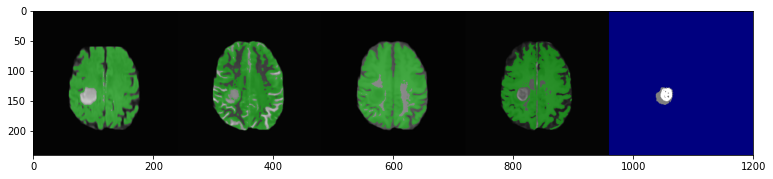

In [13]:
imgGrayMatterF = SimpleITK.ConfidenceConnected(image1=imgFSmooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=0.2,
                                                replaceValue=labelGrayMatter)

imgGrayMatterT2 = SimpleITK.ConfidenceConnected(image1=imgT2Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=10,
                                                multiplier=0.2,
                                                replaceValue=labelGrayMatter)
imgGrayMatterT1 = SimpleITK.ConfidenceConnected(image1=imgT1Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=0.2,
                                                replaceValue=labelGrayMatter)

imgGrayMatterTC = SimpleITK.ConfidenceConnected(image1=imgTCSmooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=0.2,
                                                replaceValue=labelGrayMatter)

imgGrayMatterLabel = SimpleITK.ConfidenceConnected(image1=labelOrignal, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=0.2,
                                                replaceValue=2)


imgFSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgFSmooth), 
                                imgGrayMatterF.GetPixelID())
imgT2SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT2Smooth), 
                                imgGrayMatterT2.GetPixelID())
imgT1SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgT1Smooth), 
                                imgGrayMatterT1.GetPixelID())
imgTCSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgTCSmooth), 
                                imgGrayMatterTC.GetPixelID())
imgLabelInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(labelOrignal), 
                                imgGrayMatterLabel.GetPixelID())

sitk_tile_vec([SimpleITK.LabelOverlay(imgFSmoothInt[:,:,idxSlice], 
                                      imgGrayMatterF[:,:,idxSlice]),
               SimpleITK.LabelOverlay(imgT2SmoothInt[:,:,idxSlice], 
                                     imgGrayMatterT2[:,:,idxSlice]),
              SimpleITK.LabelOverlay(imgT1SmoothInt[:,:,idxSlice], 
                                     imgGrayMatterT1[:,:,idxSlice]),
              SimpleITK.LabelOverlay(imgTCSmoothInt[:,:,idxSlice], 
                                     imgGrayMatterTC[:,:,idxSlice]),
              SimpleITK.LabelOverlay(imgLabelInt[:,:,idxSlice], 
                                     imgGrayMatterLabel[:,:,idxSlice])])





LGG


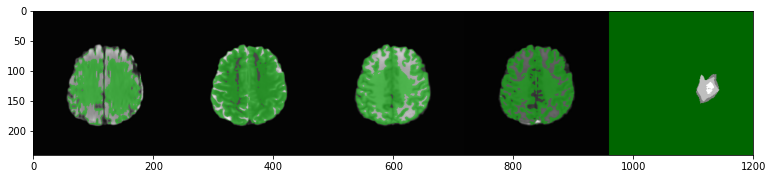

In [14]:
print("LGG")
imgGrayMatterLF = SimpleITK.ConfidenceConnected(image1=imgLFSmooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=0.01,
                                                replaceValue=labelGrayMatter)

imgGrayMatterLT2 = SimpleITK.ConfidenceConnected(image1=imgLT2Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=0.01,
                                                replaceValue=labelGrayMatter)
imgGrayMatterLT1 = SimpleITK.ConfidenceConnected(image1=imgLT1Smooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=0.01,
                                                replaceValue=labelGrayMatter)

imgGrayMatterLTC = SimpleITK.ConfidenceConnected(image1=imgLTCSmooth, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=0.01,
                                                replaceValue=labelGrayMatter)

imgGrayMatterLabelL = SimpleITK.ConfidenceConnected(image1=labelLOrignal, 
                                                seedList=lstSeeds,
                                                numberOfIterations=3,
                                                multiplier=0.2,
                                                replaceValue=labelGrayMatter)

imgLFSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgLFSmooth), 
                                imgGrayMatterF.GetPixelID())
imgLT2SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgLT2Smooth), 
                                imgGrayMatterT2.GetPixelID())
imgLT1SmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgLT1Smooth), 
                                imgGrayMatterT1.GetPixelID())
imgLTCSmoothInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(imgLTCSmooth), 
                                imgGrayMatterTC.GetPixelID())
imgLabelLInt = SimpleITK.Cast(SimpleITK.RescaleIntensity(labelLOrignal), 
                                imgGrayMatterLabelL.GetPixelID())

sitk_tile_vec([SimpleITK.LabelOverlay(imgLFSmoothInt[:,:,idxSlice], 
                                      imgGrayMatterLF[:,:,idxSlice]),
               SimpleITK.LabelOverlay(imgLT2SmoothInt[:,:,idxSlice], 
                                     imgGrayMatterLT2[:,:,idxSlice]),
              SimpleITK.LabelOverlay(imgLT1SmoothInt[:,:,idxSlice], 
                                     imgGrayMatterLT1[:,:,idxSlice]),
              SimpleITK.LabelOverlay(imgLTCSmoothInt[:,:,idxSlice], 
                                     imgGrayMatterLTC[:,:,idxSlice]),
               SimpleITK.LabelOverlay(imgLabelLInt[:,:,75], 
                                     imgGrayMatterLabelL[:,:,75])])

**Multi-Modal Segmentation**

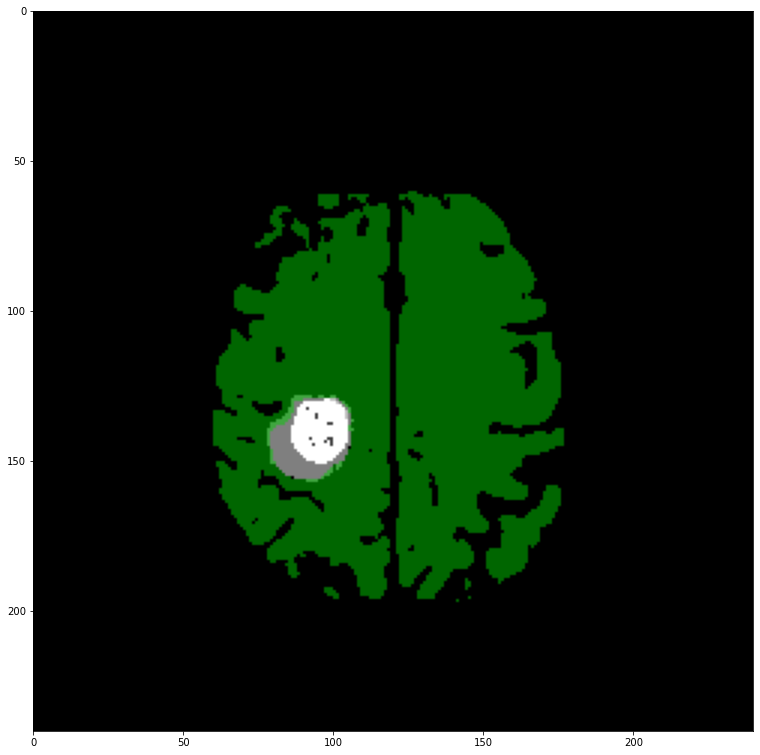

In [15]:
imgComp = SimpleITK.Compose(imgFSmooth, imgT2Smooth,imgT1Smooth,imgTCSmooth)

imgGrayMatterComp = SimpleITK.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=1,
                                               multiplier=0.1,
                                               replaceValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgLabelInt[:,:,idxSlice], 
                                 imgGrayMatterComp[:,:,idxSlice]))



LGG


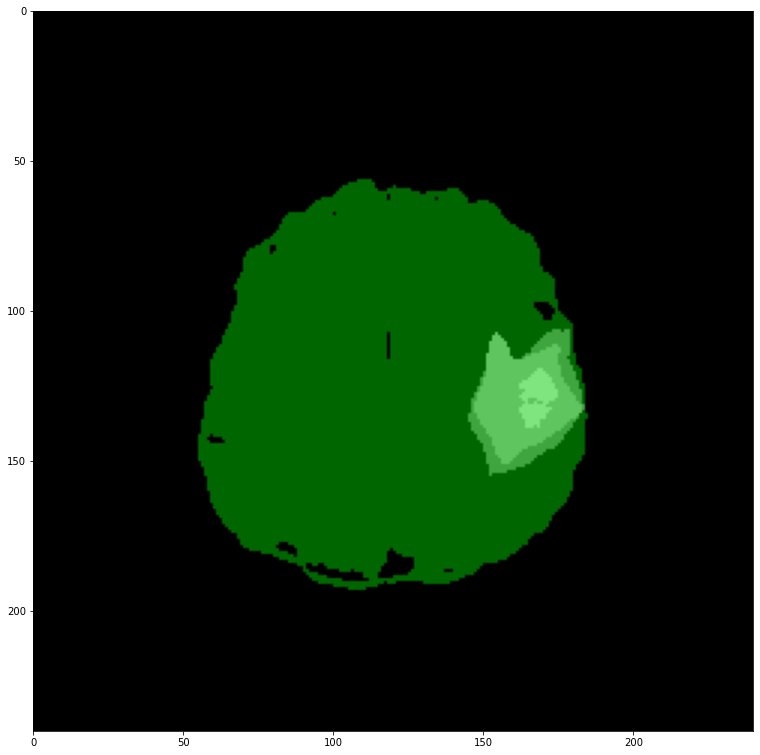

In [16]:
print("LGG")
imgComp = SimpleITK.Compose(imgLFSmooth, imgLT2Smooth,imgLT1Smooth,imgLTCSmooth)

LimgGrayMatterComp = SimpleITK.VectorConfidenceConnected(image1=imgComp, 
                                               seedList=lstSeeds,
                                               numberOfIterations=1,
                                               multiplier=0.1,
                                               replaceValue=labelGrayMatter)

sitk_show(SimpleITK.LabelOverlay(imgLabelLInt[:,:,75], 
                                 LimgGrayMatterComp[:,:,idxSlice]))

In [17]:
SimpleITK.WriteImage(imgGrayMatterComp, "GrayMatterHGG.mhd")

In [18]:
SimpleITK.WriteImage(imgGrayMatterComp, "GrayMatterLGG.mhd")